<a href="https://colab.research.google.com/github/ivanpalenciab/Prediccion-atlantico/blob/modelado-tres-modos/1_XG_boost_EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [4]:
def busqueda(datos_entrenamiento,datos_validacion):
  CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
  learning_rate = [0.01, 0.1, 0.2]
  max_depth = [2,3, 4, 5,6,7,8]
  subsample = [0.8, 0.9, 1.0]
  colsample_bytree = [0.7,0.8, 0.9, 1.0]

  errores_learning_rate = []
  errores_max_depth = {"i":{"j":[]}}
  errores = []

  X_train = datos_entrenamiento[CARACTERISTICAS]
  y_train =  datos_entrenamiento.PROMEDIO

  X_test = datos_validacion[CARACTERISTICAS]
  y_test = datos_validacion.PROMEDIO

  for i in learning_rate:
    for j in max_depth:
      for k in subsample:
        reg = xgb.XGBRegressor( base_score= None , booster= None ,
                              n_estimators= 1000 ,
                              early_stopping_rounds= 50 ,
                              subsample=k,
                              max_depth= j ,
                              learning_rate= i )


        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)
        y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
        y_predict = pd.Series(y_predict)

        score = np.sqrt(mean_absolute_percentage_error(y_predict,datos_validacion.PROMEDIO))

        errores.append((i,j,k,score))


  indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])
  print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
  print("El índice de la tupla con el número más pequeño es:", indice)
  print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

In [5]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/emd_modes/Residuo.csv")
modos = [modo_1,modo_2,residuo]

for i in modos:
  i["FECHA"] = pd.to_datetime(i["FECHA"],format='%Y-%m-%d')
  i.set_index("FECHA", inplace=True)


<Axes: xlabel='FECHA'>

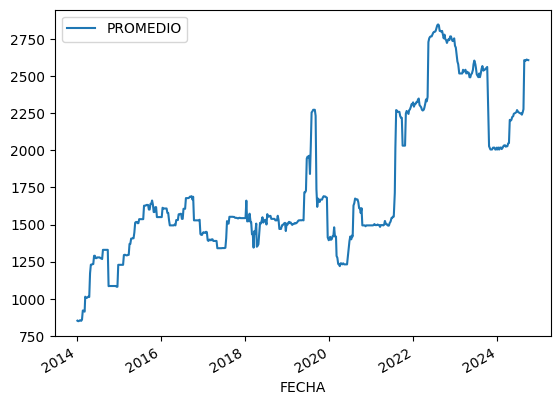

In [6]:
datos_emd = modo_1 + modo_2 + residuo
datos_emd.plot()

In [7]:
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [8]:
PASOS = 7

In [9]:
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]

# Modelaremos el primer modo

In [10]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434


In [11]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

In [12]:
total_datos=len(modo_1.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_1[:division_entrenamiento]
datos_validacion = modo_1[division_entrenamiento:division_validacion]
datos_testeo = modo_1[division_validacion:total_datos]

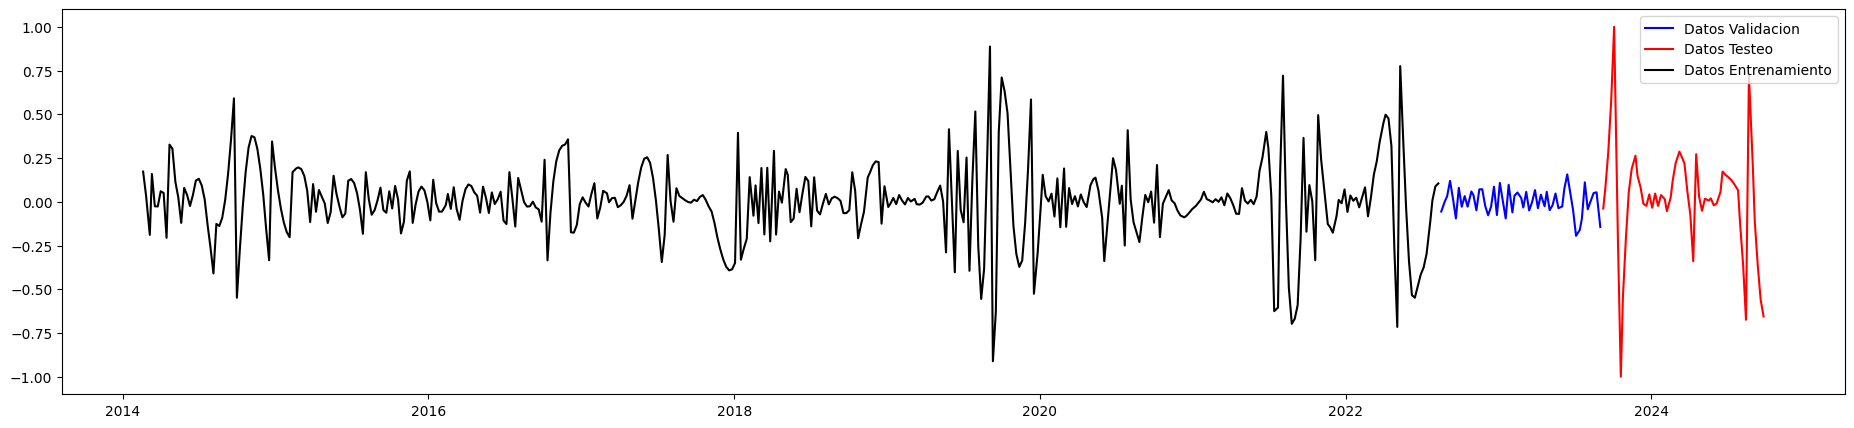

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_m1,datos_validacion_m1)

El número más pequeño en la posición 3 de las tuplas es: 3.1816149
El índice de la tupla con el número más pequeño es: 59
el learning rate es 0.2 el max_depth es 7 y el subsample es 1.0


In [14]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_1_sup = modo_1_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_1_sup[:division_validacion]) :
    train = modo_1_sup.iloc[train_idx]
    test = modo_1_sup.iloc[val_idx]

    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample= 0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_1 = reg.predict(X_test)
    validacion_modo_1 = pd.Series(validacion_modo_1)
    preds.append(validacion_modo_1)
    score = np.sqrt(mean_squared_error(validacion_modo_1,y_test))
    mae = mean_absolute_error(validacion_modo_1,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_1 = reg.predict(datos_validacion_m1[CARACTERISTICAS])
prediccion_modo_1 = reg.predict(datos_testeo_m1[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.1271926760673523 
Puntuaciones plegar: [0.06752702, 0.0431248, 0.2709262] 
Error Absoluto medio entre pliegues 0.09628042578697205
porcentaje de error absoluto medio entre pliegues 26.62818717956543


In [15]:
score = np.sqrt(mean_squared_error(datos_testeo_m1[OBJETIVO],prediccion_modo_1))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.2827931046485901


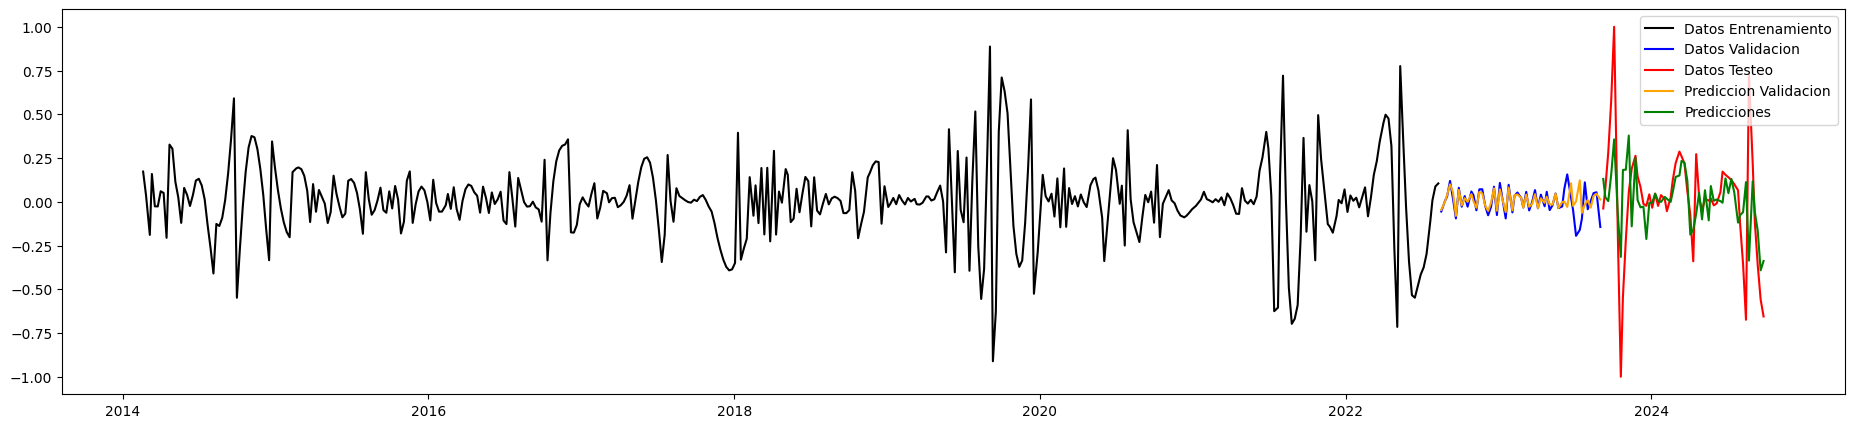

In [16]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m1.index,validacion_modo_1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m1.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [17]:
validacion_modo_1 = modo_1_scaler.inverse_transform(validacion_modo_1.reshape(-1, 1))
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

# Modelaremos el segundo modo

In [18]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053


In [19]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

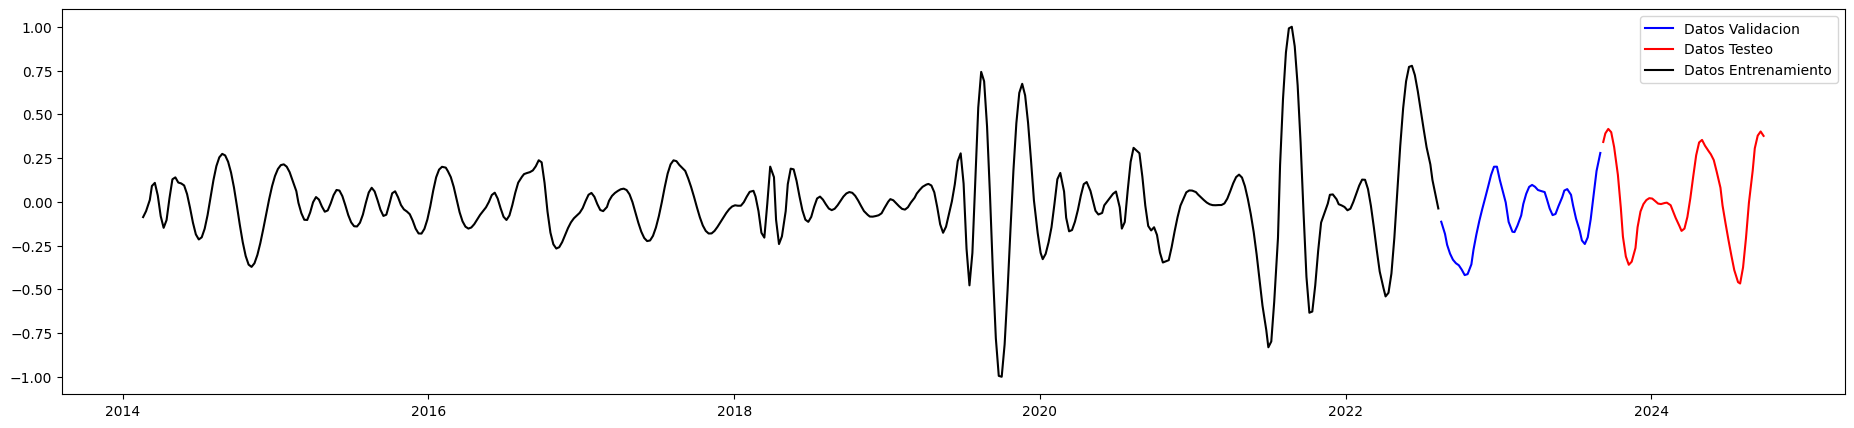

In [20]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_m2,datos_validacion_m2)

El número más pequeño en la posición 3 de las tuplas es: 0.58621264
El índice de la tupla con el número más pequeño es: 39
el learning rate es 0.1 el max_depth es 8 y el subsample es 0.8


In [21]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_2_sup = modo_2_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_2_sup[:division_validacion]) :
    train = modo_2_sup.iloc[train_idx]
    test = modo_2_sup.iloc[val_idx]

    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample= 0.9
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_2 = reg.predict(X_test)
    validacion_modo_2 = pd.Series(validacion_modo_2)
    preds.append(validacion_modo_2)
    score = np.sqrt(mean_squared_error(validacion_modo_2,y_test))
    mae = mean_absolute_error(validacion_modo_2,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_2 = reg.predict(datos_validacion_m2[CARACTERISTICAS])
prediccion_modo_2 = reg.predict(datos_testeo_m2[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.03868928179144859 
Puntuaciones plegar: [0.04750239, 0.033742208, 0.03482324] 
Error Absoluto medio entre pliegues 0.032485704869031906
porcentaje de error absoluto medio entre pliegues 1.0269489288330078


In [22]:
score = np.sqrt(mean_squared_error(datos_testeo_m2[OBJETIVO],prediccion_modo_2))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.08910949528217316


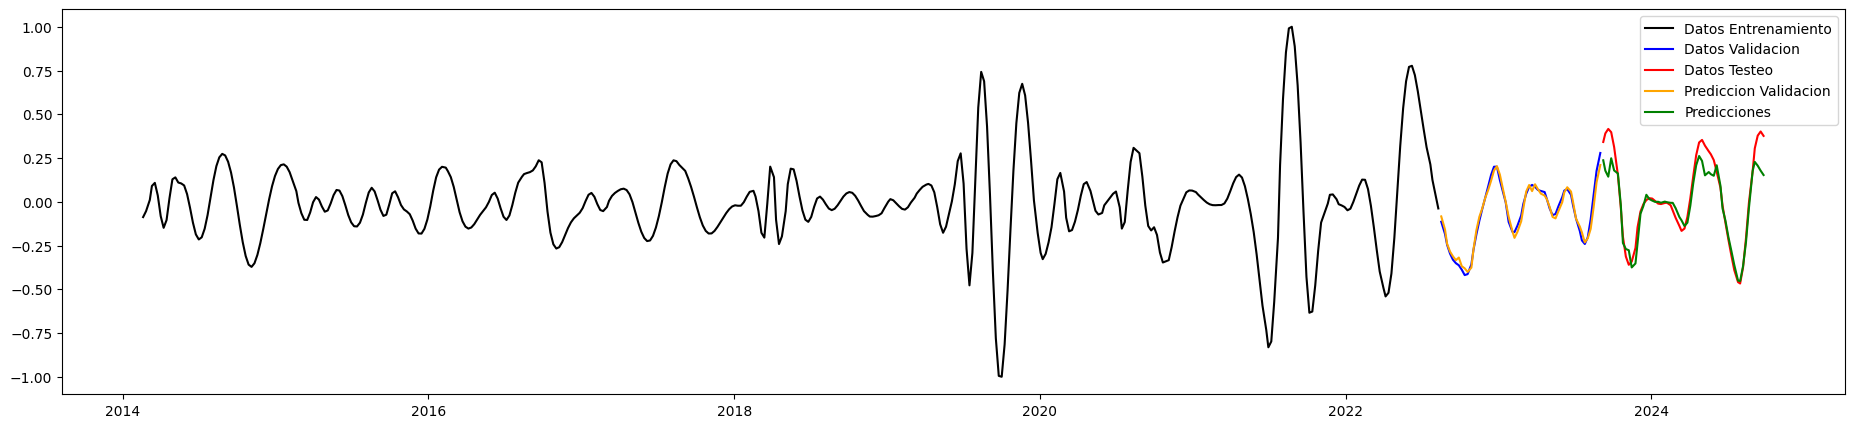

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m2.index,validacion_modo_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m2.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [24]:
validacion_modo_2 = modo_2_scaler.inverse_transform(validacion_modo_2.reshape(-1, 1))
prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Modelaremos el residuo

In [25]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638,-1.000000
2014-02-26,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115,-0.999638
2014-03-07,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275,-0.998115
2014-03-12,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960,-0.995275
2014-03-19,-0.906428,-0.925414,-0.941837,-0.955854,-0.967619,-0.977288,-0.985017,-0.990960


In [26]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

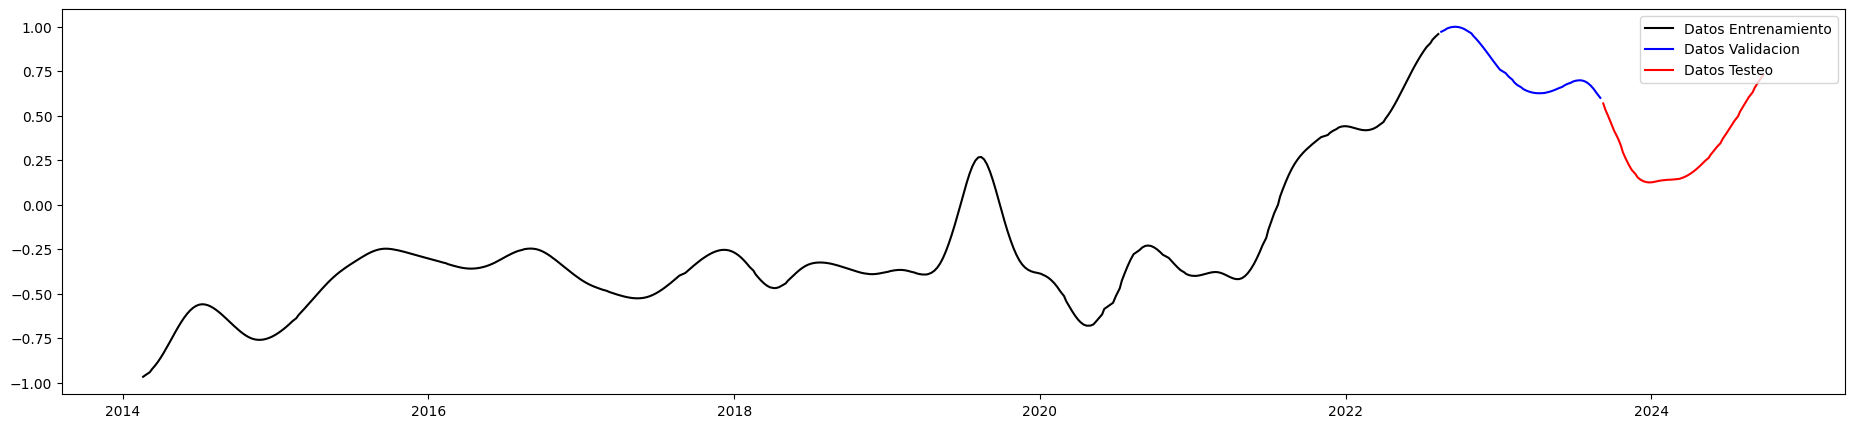

In [27]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [29]:
busqueda(datos_entrenamiento_residuo,datos_validacion_residuo)

El número más pequeño en la posición 3 de las tuplas es: 0.18674535
El índice de la tupla con el número más pequeño es: 21
el learning rate es 0.1 el max_depth es 2 y el subsample es 0.8


In [30]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
residuo = residuo_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(residuo_sup[:division_validacion]) :
    train = residuo_sup.iloc[train_idx]
    test = residuo_sup.iloc[val_idx]



    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 8 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_residuo = reg.predict(X_test)
    validacion_residuo = pd.Series(validacion_residuo)
    preds.append(validacion_residuo)
    score = np.sqrt(mean_squared_error(validacion_residuo,y_test))
    mae = mean_absolute_error(validacion_residuo,y_test)
    mape = mean_absolute_percentage_error(validacion_residuo,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_residuo = reg.predict(datos_validacion_residuo[CARACTERISTICAS])
prediccion_residuo = reg.predict(datos_testeo_residuo[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.04182112216949463 
Puntuaciones plegar: [0.09620504, 0.0149072185, 0.014351102] 
Error Absoluto medio entre pliegues 0.03770390525460243
porcentaje de error absoluto medio entre pliegues 0.046106819063425064


In [31]:
score = np.sqrt(mean_squared_error(datos_testeo_residuo[OBJETIVO],prediccion_residuo))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.03553219139575958


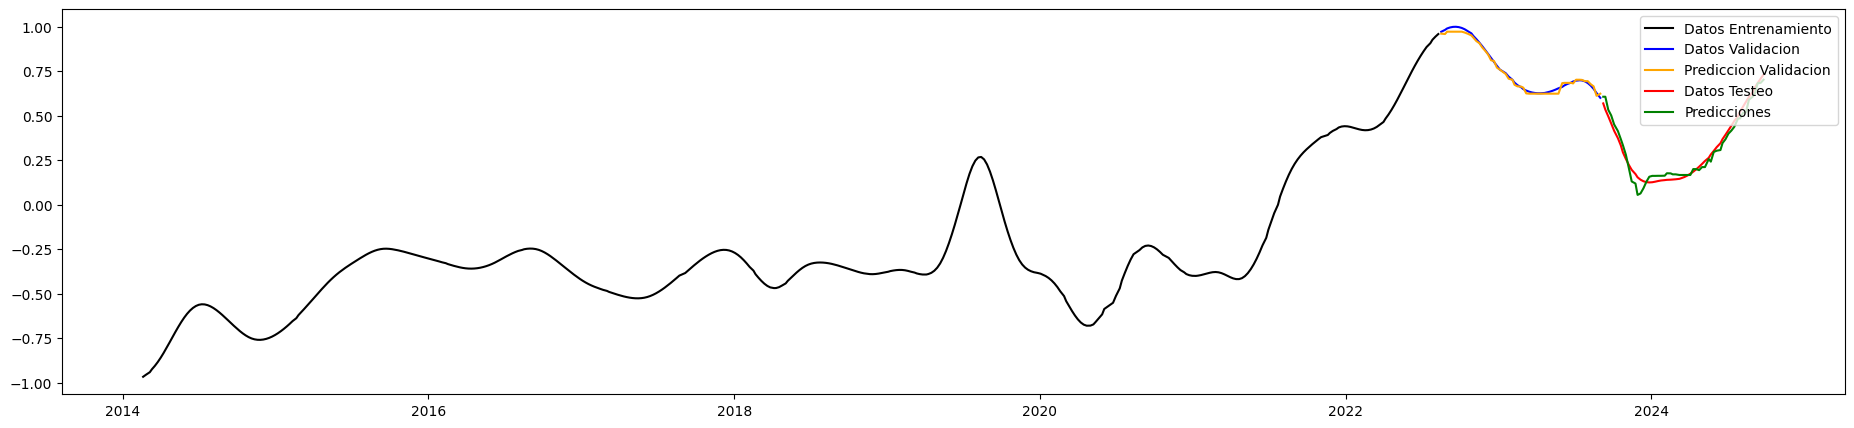

In [32]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,validacion_residuo,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [33]:
validacion_residuo = residuo_scaler.inverse_transform(validacion_residuo.reshape(-1, 1))
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [34]:
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_residuo

In [35]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

Metricas validacion

In [43]:
validacion = validacion_modo_1 + validacion_modo_2 + validacion_residuo
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion} o {round(EPAM_validacion *100,2)} %")

La raiz del error cuadratico medio del modelo es: 26.839890001095657 
el error absoluto medio del modelo es: 20.512763129340236 
Error porcentual absoluto medio del modelo es: 0.007830418176743334 o 0.78 %


Metricas de testeo del modelo

In [44]:
recm = np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO))
eam = mean_absolute_error( predicciones_emd,datos_testeo.PROMEDIO)
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.PROMEDIO)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM} o {round(EPAM * 100 , 2)} %")

La raiz del error cuadratico medio del modelo es: 69.22358913311288 
el error absoluto medio del modelo es: 54.70052664620518 
Error porcentual absoluto medio del modelo es: 0.025211401911231685 o 2.52 %


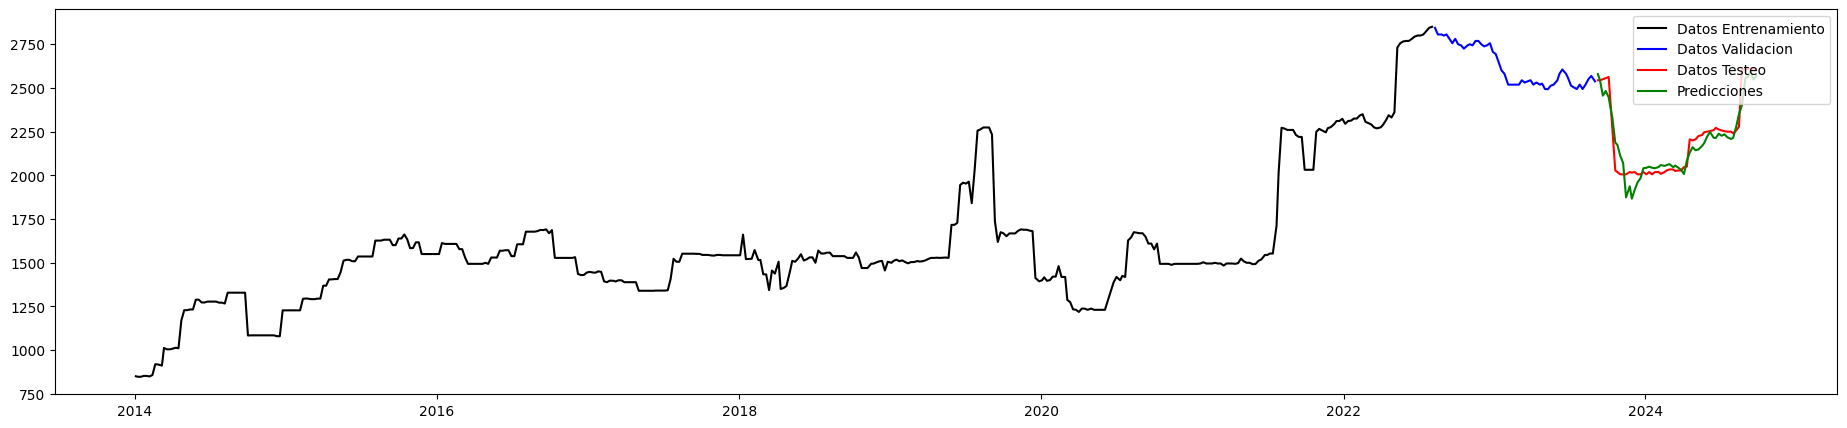

In [38]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

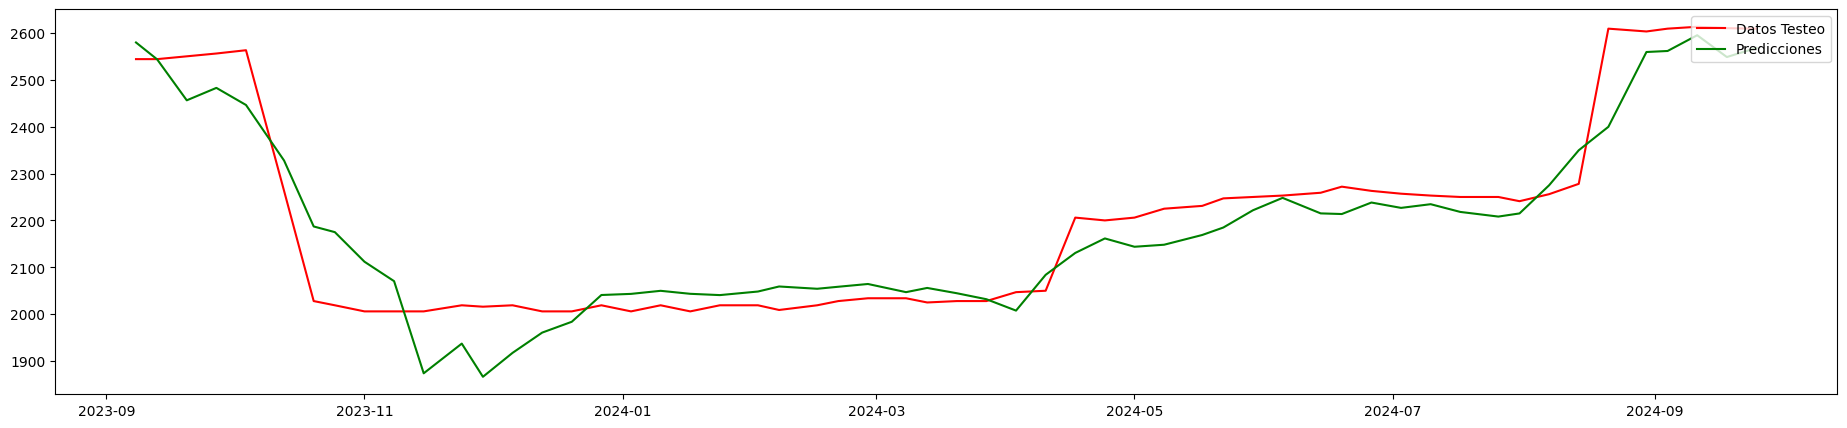

In [39]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [40]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['PROMEDIO'])
testeo = pd.DataFrame(predicciones_emd,index=datos_testeo.index,columns=['PROMEDIO'])

In [41]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/validacion_xgboost.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Pruebas/Predicciones/EMD/testeo_xgboost.csv",index=True)